# Overview
This notebook will examine quantitative 7T MRI measures projected onto hippocampal midthickness surfaces and averaged across 10 subjects. At the end, we will combine this with Histology data and examine conserved features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob

In [2]:
micapipe_dir = '../sourcedata/Supersession_PNI'
hippunfold_dir = '../hippunfold/PNI_v1.3.0_super/hippunfold'

subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = ''
hemis = ['L','R']
labels = ['hipp','dentate'] 

# here we will generate multiple depth-wise surfaces
layers = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(layers>=0,  layers <=1))[0]
ind = [range(7262), range(7262,7262+1788)]

In [3]:
features = ['T1map','MTR','T2star','FA','ADC']
for s,sub in enumerate(subs):
    cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
    !{cmd}
    for h,hemi in enumerate(hemis):
        for l,layer in enumerate(layers):
            cmd1 = f'wb_command -surface-cortex-layer '\
                f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_inner.surf.gii '\
                f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_outer.surf.gii '\
                f'{layer} '\
                f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii'
            !{cmd1}
            for f,feature in enumerate(features):
                cmd2 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii '\
                    f'-trilinear'
                !{cmd2}

In [4]:
nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii')

In [45]:
features = ['T1map','MTR','T2star','FA','ADC']
hipp_dat = np.zeros([7262,2,len(subs),len(layers),len(features)])*np.nan

for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            for l,layer in enumerate(layers):
                try:
                    d = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii')
                    hipp_dat[:,h,s,l,f] = d.darrays[0].data
                except:
                    print(f'sub-{sub}_{hemi}_{feature} not found')

In [46]:
hipp_dat.shape

(7262, 2, 10, 25, 5)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


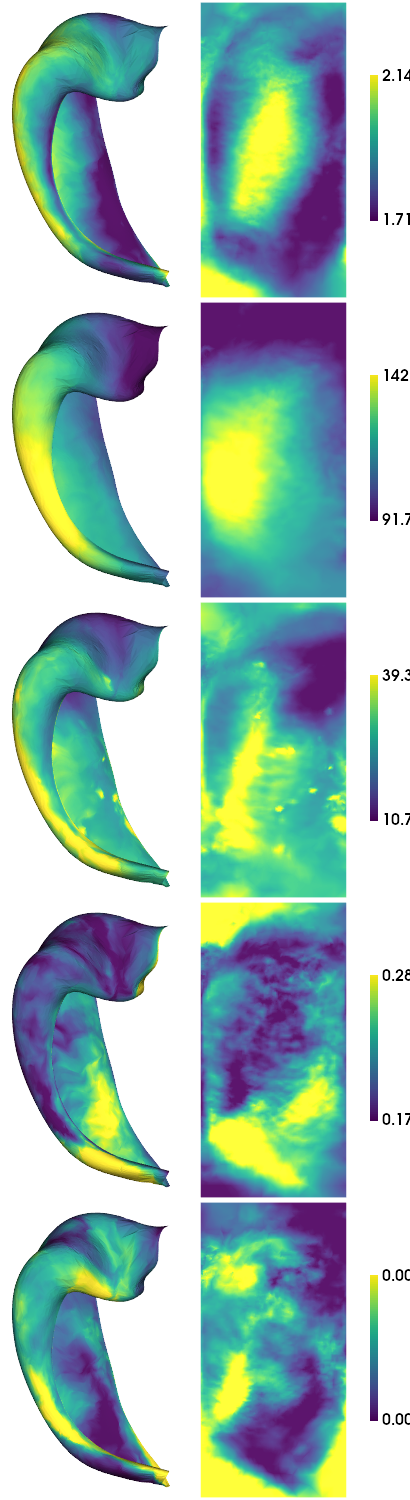

In [89]:
cdata = np.nanmean(hipp_dat,axis=(1,2))
plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,:],axis=1), color_bar=('right'), hemis=['L'], labels=['hipp'], share='row', tighten_cwindow=True, embed_nb=True)

In [87]:
import imp
imp.reload(plotting)

<module 'plotting' from '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox/plotting.py'>

In [88]:
!mkdir img_struct
for i in range(5):
    plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,i],axis=1), labels=['hipp'], color_bar=('right'), hemis=['L'], share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename=f'img_struct/{i}.png')

mkdir: cannot create directory ‘img_struct’: File exists


In [82]:
cdata.shape

(7262, 25, 5)

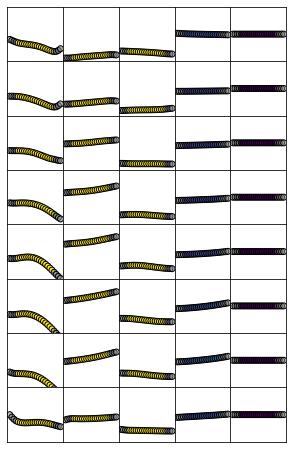

In [57]:
# let's look at some laminar profiles (Ant to Post)
nsamp=8
sampAP = np.linspace(0,254,nsamp+1).astype('int') #NOTE: here we cut off the 20% anterior and posterior since they show a lot of noise!

fig, ax = plt.subplots(nrows=nsamp, ncols=len(features), figsize=(1*len(features),1*nsamp))
for s in range(len(features)):
    
    cdat,_,_ = utils.density_interp('0p5mm','unfoldiso',cdata[:,:,s],label='hipp')
    cdat = np.reshape(cdat,[126,254,25])
    l = np.nanmean(cdat[:,:,gm],axis=2).flatten()
    # l = utils.bound_cdata(l)
    lims = [min(l)-.5, max(l)+.5]
    
    for i in range(nsamp):
        dat = np.nanmean(cdat[:,sampAP[i]:sampAP[i+1],:],axis=(0,1))
        col = plt.cm.viridis(dat)
        col[:,:][layers<0] = 0.5
        col[:,:][layers>1] = 0.5
        ax[i,s].scatter(layers,dat, c=col, edgecolors='black')
        ax[i,s].set_ylim(lims)
        # ax[i,s].axis('off')
        ax[i,s].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)

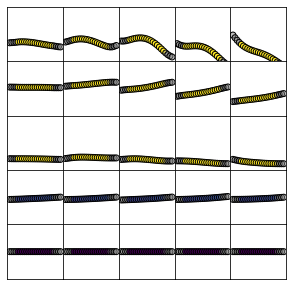

In [59]:
# let's look at some laminar profiles (Prox to Dist)
nsamp=5
sampPD = np.linspace(0,126,nsamp+1).astype('int')

fig, ax = plt.subplots(nrows=len(features), ncols=nsamp, figsize=(1*nsamp,1*len(features)))
for s in range(len(features)):
    
    cdat,_,_ = utils.density_interp('0p5mm','unfoldiso',cdata[:,:,s],label='hipp')
    cdat = np.reshape(cdat,[126,254,25])
    l = np.nanmean(cdat[:,:,gm],axis=2).flatten()
    # l = utils.bound_cdata(l)
    lims = [min(l)-.5, max(l)+.5]
    
    for i in range(nsamp):
        dat = np.nanmean(cdat[sampPD[i]:sampPD[i+1],:,:],axis=(0,1))
        col = plt.cm.viridis(dat)
        col[:,:][layers<0] = 0.5
        col[:,:][layers>1] = 0.5
        ax[s,nsamp-i-1].scatter(layers,dat, c=col, edgecolors='black')
        ax[s,nsamp-i-1].set_ylim(lims)
        # ax[s,nsamp-i-1].axis('off')
        ax[s,nsamp-i-1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)

## Add histology data
Since the histology has only one hemisphere and no DG, we will heep only this data from MRI

In [33]:
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [62]:
downsampled_histo.shape

(7262, 17, 11)

In [65]:
cdata[:,gm,:].shape

(7262, 17, 5)

In [66]:
downsampled_histo = np.load("../checkpoints/struct-HISTO-proc-midsurfaces.npy")
struct_data = np.concatenate((downsampled_histo,cdata[:,gm,:]),axis=2)
struct_data.shape

(7262, 17, 16)

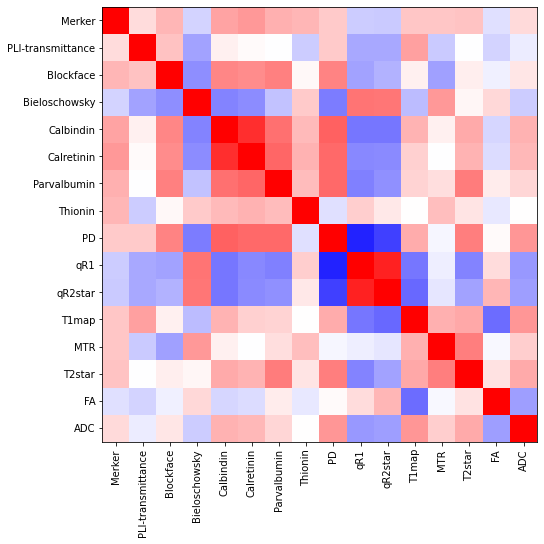

In [67]:
# correlation between features
feat_corr = np.corrcoef(struct_data.reshape(7262*17,16).T)
allfeatures = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'PD',\
               'qR1', 'qR2star', 'T1map', 'MTR', 'T2star', 'FA', 'ADC']

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

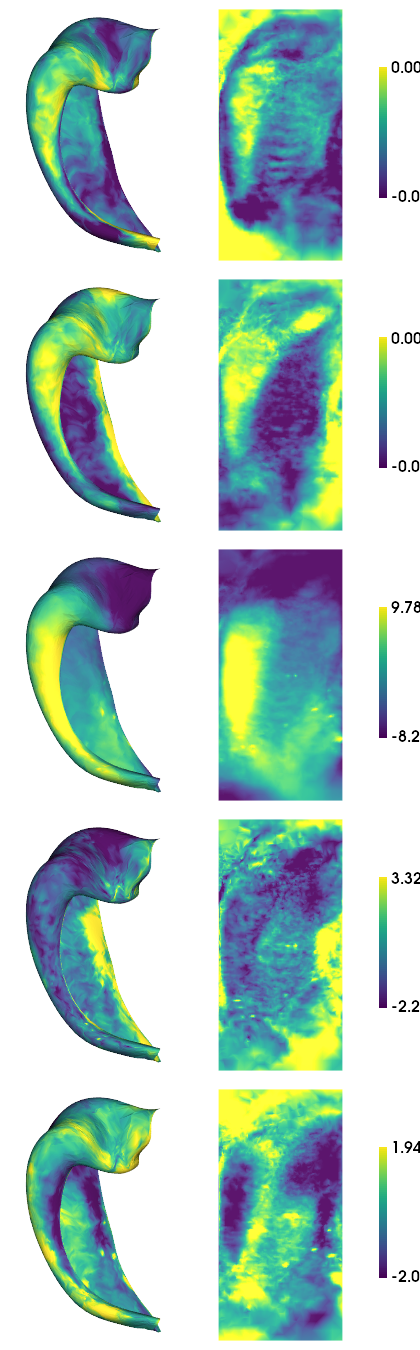

In [70]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(struct_data.reshape(7262,17*16), sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], size=[350,270], color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

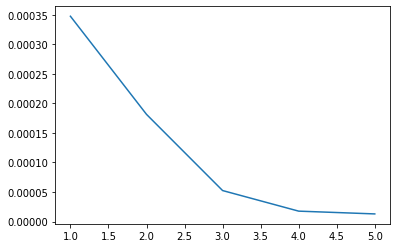

In [71]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)

In [ ]:
mmgm.gradients_.shape